In [2]:
import pandas as pd
import json

with open("repeaters.json", 'r') as f:
    data = json.load(f)

dataframe = []
for key, val in data.items():
    dets = []
    for v in val.keys():
        if v not in ['ra', 'gl', 'last_burst_date', 'dm', 'dec', 'publication', 'localized', 'ne2001', 'gb', 'ymw16', 'previous_name']:
            dets.append(v)

    timestamps = []
    for det in dets:
        timestamps.append(val[det]['timestamp']['value'])
    dataframe.append({"eventname": key, "datetime": timestamps})

pd.DataFrame(dataframe).explode('datetime').to_csv('repeaters.csv', index=False)

In [119]:
from astropy.time import Time
chosen_name = 'FRB20220912A' # 👍 (336)
# chosen_name = 'FRB20180916B' # 👍 (111)
# chosen_name = 'FRB20191106C' # ? (17)
# chosen_name = 'FRB20200929C' # ? 👍 (16)
# chosen_name = 'FRB20201130A' # ? (12)
# chosen_name = 'FRB20190804E' # ? 👍 (8)
# chosen_name = 'FRB20190915D' # ? (5)
# chosen_name = 'FRB20201221B' # (6)

data = pd.read_csv('repeaters.csv', parse_dates=['datetime'])
selected = data.sort_values(by='datetime')
selected[chosen_name] = (selected['eventname'] == chosen_name).astype(int)
sampled = selected.set_index('datetime').resample('d')[chosen_name].sum()
sampled.sum()

336

(<Quantity 8.80196631 d>, <Quantity 1.>)

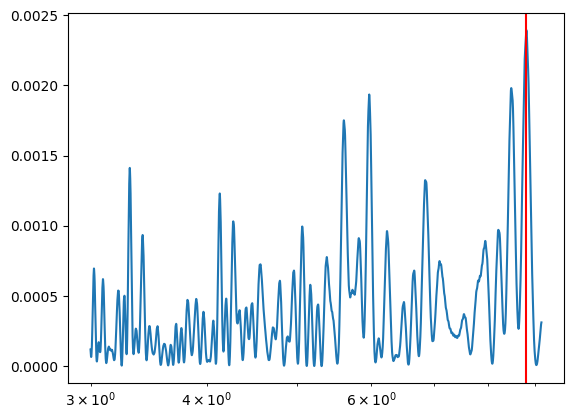

In [128]:
import numpy as np
import seaborn as sns

from astropy.timeseries import LombScargle
import astropy.units as u

time = Time(sampled.index.to_numpy())
obs = sampled.to_numpy()

freq_min = 1/(len(sampled) * .005 * u.day)
freq_max = 1 / (3 * u.day)

freq_grid = np.linspace(freq_min,freq_max, 10_000)

LS = LombScargle(time, obs)
power = LS.power(freq_grid)

p = 1/freq_grid[np.nanargmax(power)]

g = sns.lineplot(x=1/freq_grid, y=power)
g.axvline(p.value, color='red', alpha=1)
g.set_xscale('log')

p, LS.false_alarm_probability(np.nanmax(power.value))